# Detecting at-risk students

In this chapter, we attempt to replicate the student learning achievement model
originally introduced by Al-Shabandar et al. {cite}`alshabandar_2019`, which aims to
identify students at risk of failure or withdrawal from an online course.

The approach of Al-Shabandar consists of the following steps:

1. **Data aggregation:**

   Student click interactions are aggregated by activity type.
   This aggregation process computes both the total sum of clicks and interaction
   frequency for each distinct activity type.

2. **Data cleaning:**

   Highly correlated features (>0.8) and near-zero variance predictors are removed.

3. **Data normalization:**

   Following this, features are normalized with the Yeo-Johnson transformation.
   Additionally, to address the issue of class imbalance, the Synthetic Minority
   Over-Sampling (SMOTE) technique is applied to augment the representation of
   minority classes.

4. **Model training:**

   Four distinct machine-learning algorithms are trained and fine-tuned.
   These algorithms undergo optimization through a combination of random search and
   grid search techniques conducted on the `BBB_2013B` course dataset.
   The assessment of model performance is achieved through ten-fold cross-validation,
   with a 70/30 training/test split.

6. **Model evaluation:**

   The model's predictive capabilities are evaluated on the subsequent `BBB_2013J`
   course dataset involving several quality metrics, such as the
   F-measure, sensitivity, specificity, and AUC, to assess the model's efficacy and
   generalizability comprehensively.

```{bibliography}
:filter: docname in docnames
```

In [1]:
from shutil import rmtree
from tempfile import mkdtemp

import numpy as np
import pandas as pd
import plotly.express as px
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from IPython.display import display
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import PowerTransformer

from oulad import get_oulad

%load_ext oulad.capture

In [2]:
%%capture oulad
oulad = get_oulad()

## Data aggregation

We construct the `feature_table` DataFrame that aggregates student VLE interactions
by activity type.
Both the total sum of clicks and interaction frequency are computed.

In [3]:
%%capture -ns detecting_at_risk_students feature_table
feature_table = (
    oulad.vle.query("code_module == 'BBB' and code_presentation in ['2013B', '2013J']")
    .drop(columns=["code_module", "code_presentation"])
    .merge(oulad.student_vle[["id_student", "id_site", "sum_click"]], on="id_site")
    .groupby(["id_student", "activity_type"])
    .agg({"sum_click": ["sum", "count"]})
    .pivot_table(
        values="sum_click",
        index="id_student",
        columns="activity_type",
        fill_value=0,
    )
    .pipe(lambda df: setattr(df, "columns", df.columns.map("_".join)) or df)
    .join(
        oulad.student_info.query(
            "code_module == 'BBB' and code_presentation in ['2013B', '2013J']"
        )
        .loc[:, ["id_student", "final_result", "code_presentation"]]
        .assign(final_result=lambda df: df.final_result.isin(["Pass", "Distinction"]))
        .set_index("id_student")
    )
)
display(feature_table)

count_forumng  count_glossary  count_homepage  \
id_student                                                  
23629                24.0             0.0            16.0   
23798                76.0             1.0            77.0   
25107               321.0             1.0           114.0   
27759                47.0             2.0            46.0   
27891                56.0             0.0            20.0   
...                   ...             ...             ...   
2685831             121.0             1.0           110.0   
2691100              18.0             0.0            62.0   
2691566              18.0             0.0            17.0   
2692384             133.0             0.0           112.0   
2693772               6.0             0.0             1.0   

            count_oucollaborate  count_oucontent  count_ouelluminate  \
id_student                                                             
23629                       0.0              0.0                 0.0   
23798                       3.0              6.0                 0.0   
25107                       0.0              1.0                 1.0   
27759                       0.0              6.0                 0.0   
27891                       0.0              1.0                 0.0   
...                         ...              ...                 ...   
2685831                     0.0              0.0                 0.0   
2691100                     0.0              6.0                 0.0   
2691566                     0.0              2.0                 0.0   
2692384                     0.0              1.0                 0.0   
2693772                     0.0              0.0                 0.0   

            count_quiz  count_resource  count_sharedsubpage  count_subpage  \
id_student                                                                   
23629             15.0             2.0                  0.0            2.0   
23798             48.0            16.0                  0.0           33.0   
25107             45.0            13.0                  0.0           14.0   
27759             32.0            17.0                  0.0           24.0   
27891             19.0             6.0                  0.0            6.0   
...                ...             ...                  ...            ...   
2685831           46.0            30.0                  0.0           26.0   
2691100           40.0            49.0                  0.0           38.0   
2691566           30.0             5.0                  0.0            6.0   
2692384           32.0            54.0                  0.0           43.0   
2693772            0.0             3.0                  0.0            1.0   

            ...  sum_oucollaborate  sum_oucontent  sum_ouelluminate  sum_quiz  \
id_student  ...                                                                 
23629       ...                0.0            0.0               0.0      31.0   
23798       ...                3.0           44.0               0.0     104.0   
25107       ...                0.0            1.0               1.0      85.0   
27759       ...                0.0           17.0               0.0      88.0   
27891       ...                0.0            1.0               0.0      38.0   
...         ...                ...            ...               ...       ...   
2685831     ...                0.0            0.0               0.0     148.0   
2691100     ...                0.0           22.0               0.0     102.0   
2691566     ...                0.0           33.0               0.0      81.0   
2692384     ...                0.0            3.0               0.0      73.0   
2693772     ...                0.0            0.0               0.0       0.0   

            sum_resource  sum_sharedsubpage  sum_subpage  sum_url  \
id_student                                                          
23629                2.0                0.0          5.0      0.0   
23798

## Data cleaning

```{note}
Near-zero variance predictors are removed in the subsequent section.
It is implemented in the model training pipeline.
```

### Train test validation split

To avoid leaking statistics from our validation data into the trained model, we split
the dataset into a train/test set (`BBB_2013B` course presentation) and validation
set (`BBB_2013J` course presentation), prior to data cleaning.

In [4]:
first_course_mask = feature_table["code_presentation"] == "2013B"
train_test_set = feature_table[first_course_mask].drop(columns="code_presentation")
x_train_test = train_test_set.drop(columns="final_result")
y_train_test = train_test_set.final_result.values
validation_set = feature_table[~first_course_mask].drop(columns="code_presentation")
x_validation = validation_set.drop(columns="final_result")
y_validation = validation_set.final_result.values

### Highly correlated features removal

We identify highly correlated features (>0.8) in the train set and remove them
from both the train and validation sets.

In [5]:
x_train_test_corr = x_train_test.corr()
px.imshow(
    x_train_test_corr.round(2),
    title="Feature Correlation Matrix before feature removal",
    text_auto=True,
    color_continuous_scale="greens",
    width=800,
    height=600,
).show()

In [6]:
highly_correlated_features = (
    x_train_test_corr[(x_train_test_corr > 0.8)]
    .stack()
    .index.to_frame()
    .reset_index(drop=True)
    .pipe(lambda df: df[df[0] != df[1]])
    .apply(lambda col: "__".join(sorted([col[0], col[1]])), axis=1)
    .drop_duplicates(ignore_index=True)
    .map(lambda x: x.split("__")[0])
    .unique()
)
x_train_test = x_train_test.drop(columns=highly_correlated_features)
x_validation = x_validation.drop(columns=highly_correlated_features)
display(highly_correlated_features)

array(['count_forumng', 'count_glossary', 'count_homepage',
       'count_oucollaborate', 'count_ouelluminate', 'count_quiz',
       'count_resource', 'count_sharedsubpage', 'count_subpage',
       'count_url', 'sum_forumng', 'sum_resource'], dtype=object)

In [7]:
px.imshow(
    x_train_test.corr().round(2),
    title="Feature Correlation Matrix after feature removal",
    text_auto=True,
    color_continuous_scale="greens",
    width=800,
    height=600,
).show()

## Data normalization, model training and evaluation

In this section, we define the data normalization and model training pipeline.

As in the work of Al-Shabandar et al., we remove near-zero variance predictors
(`VarianceThreshold`), normalize the features with the Yeo-Johnson transformation
(`PowerTransformer`) and apply the Synthetic Minority Over-Sampling (`SMOTE`)
technique.

We conduct a hyperparameter grid search on 70% of the `BBB_2013B` course dataset.

```{note}
We have commented out the hyperparameter ranges and replaced them with the selected
values to reduce the execution time of this notebook.
```

Finally, we assess the model performance using the remaining 30% of the `BBB_2013B`
course, which serves as the test set.
In addition, the full `BBB_2013J` course dataset is employed as the validation set.

test_accuracy   test_f1  test_sensitivity  \
classifier                                                              
GradientBoostingClassifier       0.837069  0.859013          0.959950   
LogisticRegression               0.836638  0.851489          0.911835   
MLPClassifier                    0.844397  0.859135          0.930380   
RandomForestClassifier           0.831034  0.847872          0.919929   

                            test_specificity  test_AUC  validation_accuracy  \
classifier                                                                    
GradientBoostingClassifier          0.704247  0.832098             0.858498   
LogisticRegression                  0.758487  0.835161             0.804262   
MLPClassifier                       0.755372  0.842876             0.744273   
RandomForestClassifier              0.737445  0.828687             0.834843   

                            validation_f1  validation_sensitivity  \
classifier                                                          
GradientBoostingClassifier       0.884687                0.950560   
LogisticRegression               0.823131                0.797948   
MLPClassifier                    0.745048                0.677612   
RandomForestClassifier           0.858208                0.875933   

                            validation_specificity  validation_AUC  
classifier                                                          
GradientBoostingClassifier                0.735901        0.843230  
LogisticRegression                        0.812671        0.805309  
MLPClassifier                             0.833043        0.755328  
RandomForestClassifier                    0.780124        0.828029

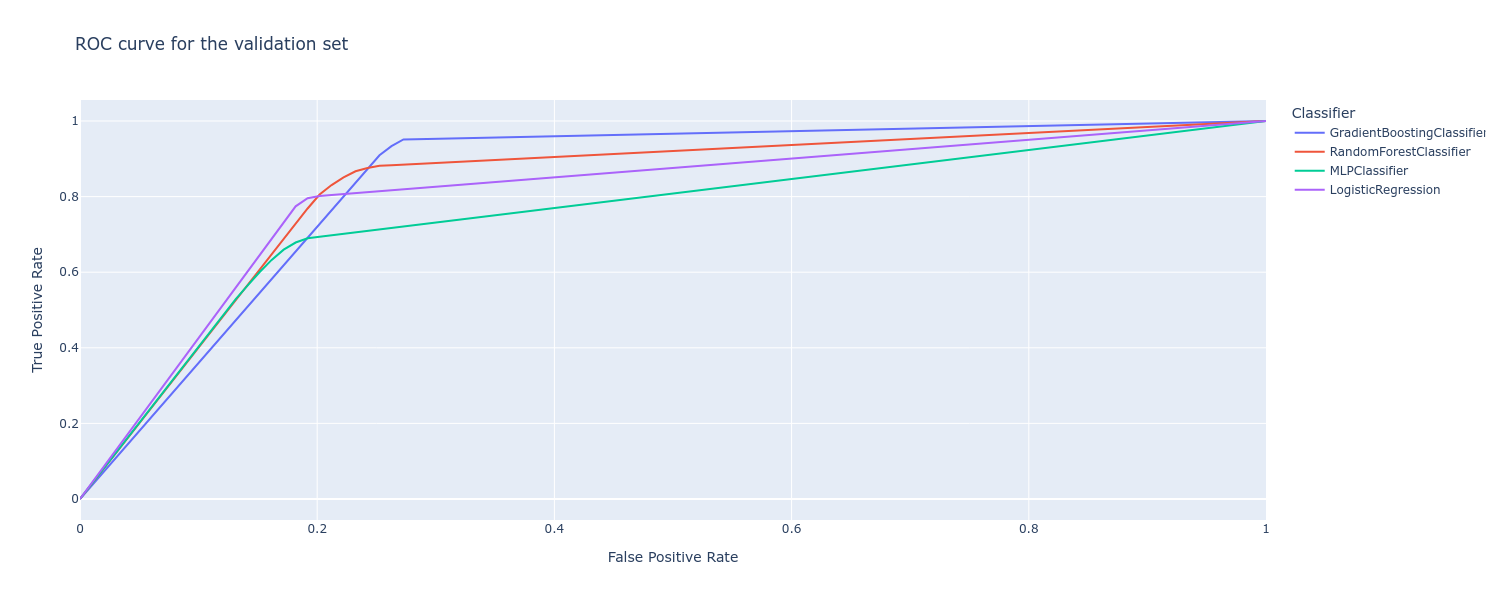

In [8]:
%%capture -ns detecting_at_risk_students scores_roc_curves
cachedir = mkdtemp()
grid = {
    GradientBoostingClassifier: {
        "classifier__learning_rate": [0.03],  # [0.03, 0.1, 0.6, 1.1, 1.6],
        "classifier__loss": ["exponential"],  # ["log_loss", "exponential"],
        "classifier__max_depth": [3],  # [3, 4, None],
        "classifier__min_samples_leaf": [40],  # list(range(10, 100, 10)),
        "classifier__min_samples_split": [20],  # list(range(10, 100, 10)),
        "classifier__n_estimators": [10],  # [10, 50, 100],
        "classifier__n_iter_no_change": [10],  # [None, 10],
    },
    RandomForestClassifier: {
        "classifier__criterion": ["gini"],  # ["gini", "entropy", "log_loss"],
        "classifier__max_depth": [3],  # [None, *list(range(1, 20, 2))],
        "classifier__min_samples_leaf": [10],  # list(range(10, 100, 10)),
        "classifier__min_samples_split": [50],  # list(range(10, 100, 10)),
        "classifier__n_estimators": [50],  # [10, 50, 100],
    },
    MLPClassifier: {
        "classifier__alpha": [0.1],  # [1/10**x for x in range(1, 7)],
        "classifier__early_stopping": [True],  # [True, False],
        "classifier__hidden_layer_sizes": [(135,)],  # (x,) for x in range(10, 200, 5),
        "classifier__learning_rate": ["constant"],  # constant, adaptive, invscaling,
        "classifier__learning_rate_init": [0.3],  # [0.001, 0.1, 0.3],
        "classifier__max_iter": [1200],
        "classifier__momentum": [0.9],  # [0.2, 0.5, 0.9],
        "classifier__solver": ["sgd"],
    },
    LogisticRegression: {
        "classifier__penalty": ["l1"],  # ["l1", "l2", None],
        "classifier__solver": ["saga"],
        "classifier__tol": [1e-4],  # [1e-03, 1e-04, 1e-05, 1e-06, 1e-07, 1e-08],
    },
}
pipe = Pipeline(
    [
        ("variance_threshold", VarianceThreshold(3)),
        ("smote", SMOTE()),
        ("power_transformer", PowerTransformer()),
        ("classifier", None),
    ],
    memory=cachedir,
)
mean_fpr = np.linspace(0, 1, 100)
scores = {
    "classifier": [],
    "test_accuracy": [],
    "test_f1": [],
    "test_sensitivity": [],
    "test_specificity": [],
    "test_AUC": [],
    "validation_accuracy": [],
    "validation_f1": [],
    "validation_sensitivity": [],
    "validation_specificity": [],
    "validation_AUC": [],
}
roc_curves = {}


def get_scores_and_roc_curves() -> tuple[dict]:
    """Computes the prediction scores and ROC curves."""

    for classifier_class, hyper_parameters in grid.items():
        tprs = []
        for _ in range(5):
            pipe.set_params(classifier=classifier_class())
            classifier = GridSearchCV(
                pipe,
                hyper_parameters,
                scoring="f1",
                n_jobs=-1,
                error_score="raise",
                cv=StratifiedKFold(n_splits=10, shuffle=True),
                refit=True,
            )
            x_train, x_test, y_train, y_test = train_test_split(
                x_train_test, y_train_test, test_size=0.3
            )
            classifier.fit(x_train, y_train)
            y_test_pred = classifier.predict(x_test)
            y_validation_pred = classifier.predict(x_validation)
            scores["classifier"].append(classifier_class.__name__)
            for name in ["test", "validation"]:
                y_true = y_test if name == "test" else y_validation
                y_pred = y_test_pred if name == "test" else y_validation_pred
                scores[f"{name}_accuracy"].append(accuracy_score(y_true, y_pred))
                scores[f"{name}_f1"].append(f1_score(y_true, y_pred))
                scores[f"{name}_sensitivity"].append(recall_score(y_true, y_pred))
                scores[f"{name}_specificity"].append(
                    recall_score(y_true, y_pred, pos_label=0)
                )
                scores[f"{name}_AUC"].append(roc_auc_score(y_true, y_pred))

            fpr, tpr, _ = roc_curve(y_validation, y_validation_pred)
            tprs.append(np.interp(mean_fpr, fpr, tpr))

        roc_curves[classifier_class.__name__] = np.mean(tprs, axis=0)

    return scores, roc_curves


scores_roc_curves = get_scores_and_roc_curves()
display(pd.DataFrame(scores_roc_curves[0]).groupby("classifier").mean())
px.line(
    pd.DataFrame(scores_roc_curves[1], index=mean_fpr)
    .melt(var_name="Classifier", value_name="True Positive Rate", ignore_index=False)
    .rename_axis(index="False Positive Rate")
    .reset_index(),
    x="False Positive Rate",
    y="True Positive Rate",
    color="Classifier",
    title="ROC curve for the validation set",
    width=800,
    height=600,
).show()
rmtree(cachedir)